## Import Library

In [588]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.linear_model import LinearRegression

## Load Dataset

In [589]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
revenue_df = pd.read_csv('https://raw.githubusercontent.com/Ezraliano/Revenue_Analysis/refs/heads/main/coffee-shop-sales-revenue.csv', delimiter='|')

# Tampilkan 5 baris pertama
print(revenue_df.head().to_markdown(index=False, numalign="left", stralign="left"))

# Tampilkan informasi kolom dan tipe datanya
print(revenue_df.info())

| transaction_id   | transaction_date   | transaction_time   | transaction_qty   | store_id   | store_location   | product_id   | unit_price   | product_category   | product_type          | product_detail              |
|:-----------------|:-------------------|:-------------------|:------------------|:-----------|:-----------------|:-------------|:-------------|:-------------------|:----------------------|:----------------------------|
| 1                | 2023-01-01         | 07:06:11           | 2                 | 5          | Lower Manhattan  | 32           | 3            | Coffee             | Gourmet brewed coffee | Ethiopia Rg                 |
| 2                | 2023-01-01         | 07:08:56           | 2                 | 5          | Lower Manhattan  | 57           | 3.1          | Tea                | Brewed Chai tea       | Spicy Eye Opener Chai Lg    |
| 3                | 2023-01-01         | 07:14:04           | 2                 | 5          | Lower Manhattan  | 59   

In [590]:
revenue_df.tail()

transaction_id transaction_date transaction_time  transaction_qty  \
149111          149452       2023-06-30         20:18:41                2   
149112          149453       2023-06-30         20:25:10                2   
149113          149454       2023-06-30         20:31:34                1   
149114          149455       2023-06-30         20:57:19                1   
149115          149456       2023-06-30         20:57:19                2   

        store_id  store_location  product_id  unit_price product_category  \
149111         8  Hell's Kitchen          44        2.50              Tea   
149112         8  Hell's Kitchen          49        3.00              Tea   
149113         8  Hell's Kitchen          45        3.00              Tea   
149114         8  Hell's Kitchen          40        3.75           Coffee   
149115         8  Hell's Kitchen          64        0.80         Flavours   

             product_type        product_detail  
149111  Brewed herbal tea         Peppermint Rg  
149112   Brewed Black tea  English Breakfast Lg  
149113  Brewed herbal tea         Peppermint Lg  
149114   Barista Espresso            Cappuccino  
149115      Regular syrup        Hazelnut syrup

## EDA

In [591]:
# Mengecek Tipe Data
revenue_df.dtypes

transaction_id        int64
transaction_date     object
transaction_time     object
transaction_qty       int64
store_id              int64
store_location       object
product_id            int64
unit_price          float64
product_category     object
product_type         object
product_detail       object
dtype: object

In [592]:
# Menganalisis Distribusi Data
numeric_columns = revenue_df.select_dtypes(include=['float64', 'int64']).columns
skewness = revenue_df[numeric_columns].apply(skew)
print("Skewness untuk setiap kolom numerik:")
print(skewness.to_markdown())

Skewness untuk setiap kolom numerik:
|                 |           0 |
|:----------------|------------:|
| transaction_id  | 6.19437e-05 |
| transaction_qty | 0.799811    |
| store_id        | 0.225978    |
| product_id      | 0.191764    |
| unit_price      | 8.455       |


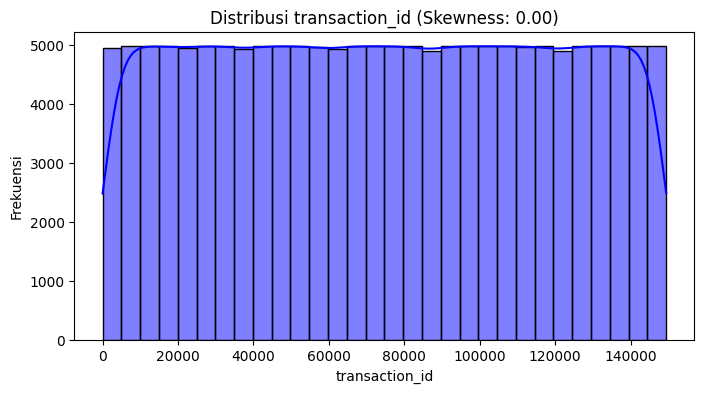

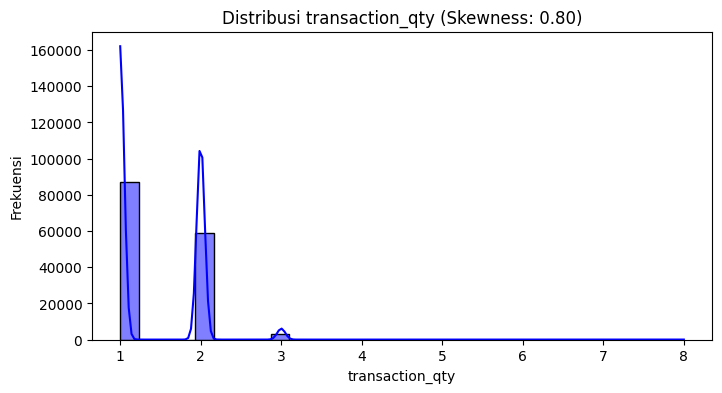

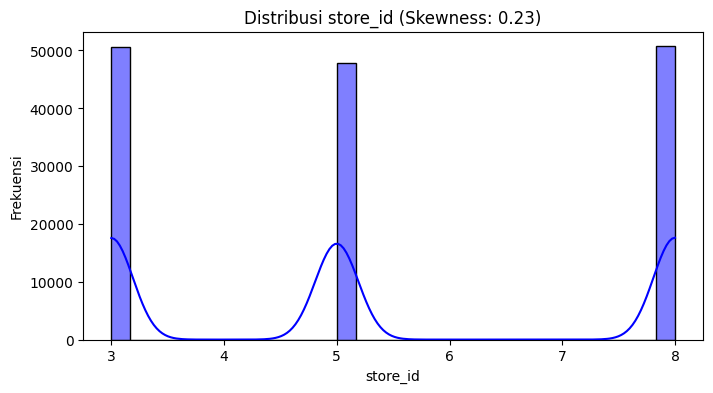

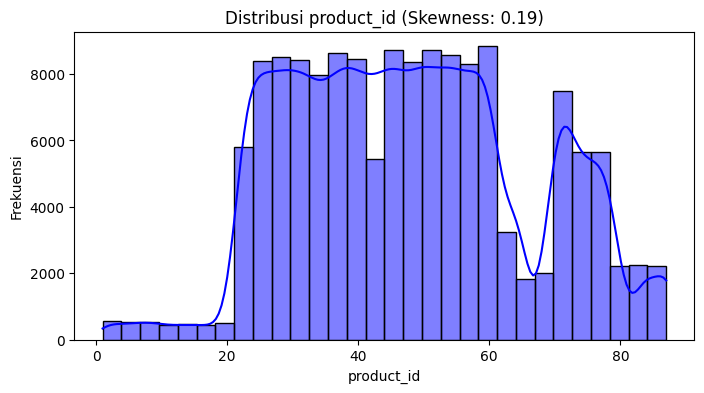

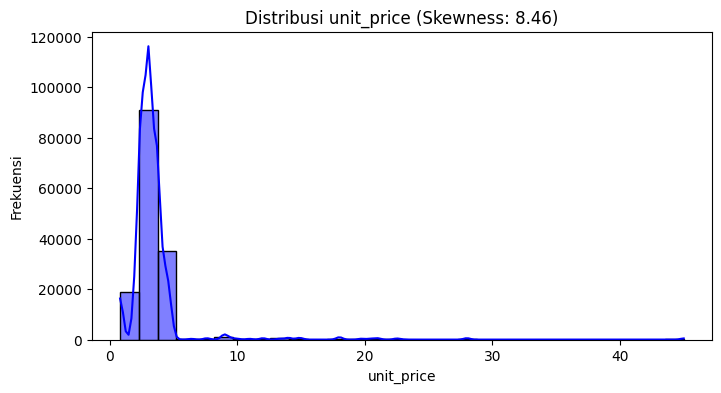

In [593]:
# Visualisasi distribusi dan skewness
for col in numeric_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(revenue_df[col], kde=True, bins=30, color='blue')
    plt.title(f'Distribusi {col} (Skewness: {skewness[col]:.2f})')
    plt.xlabel(col)
    plt.ylabel('Frekuensi')
    plt.show()

Skewness setelah Log Transformation: 1.71


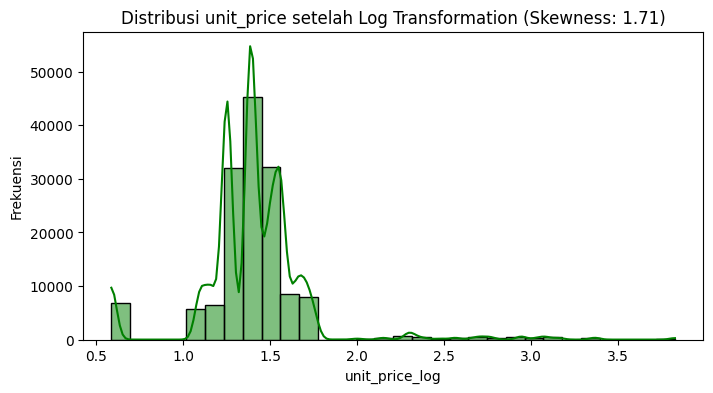

In [594]:
# Log transformation untuk unit_price
revenue_df['unit_price_log'] = np.log1p(revenue_df['unit_price'])
log_skewness = skew(revenue_df['unit_price_log'])
print(f"Skewness setelah Log Transformation: {log_skewness:.2f}")
plt.figure(figsize=(8, 4))
sns.histplot(revenue_df['unit_price_log'], kde=True, bins=30, color='green')
plt.title(f'Distribusi unit_price setelah Log Transformation (Skewness: {log_skewness:.2f})')
plt.xlabel('unit_price_log')
plt.ylabel('Frekuensi')
plt.show()

In [595]:
# Mendeteksi missing values
missing_values = revenue_df.isnull().sum()
print("Jumlah missing values untuk setiap kolom:")
print(missing_values.to_markdown())

Jumlah missing values untuk setiap kolom:
|                  |   0 |
|:-----------------|----:|
| transaction_id   |   0 |
| transaction_date |   0 |
| transaction_time |   0 |
| transaction_qty  |   0 |
| store_id         |   0 |
| store_location   |   0 |
| product_id       |   0 |
| unit_price       |   0 |
| product_category |   0 |
| product_type     |   0 |
| product_detail   |   0 |
| unit_price_log   |   0 |


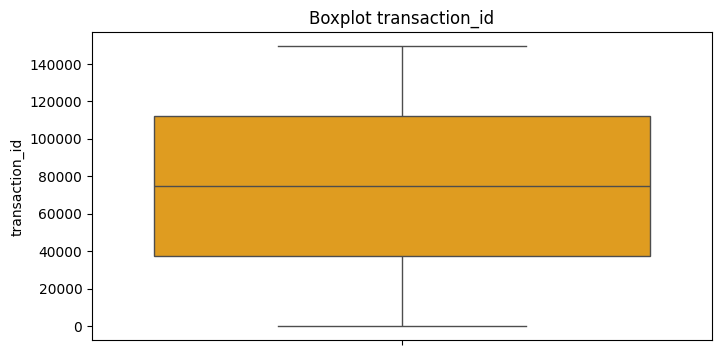

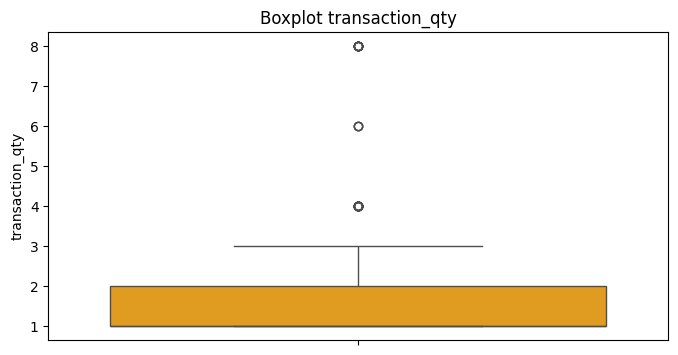

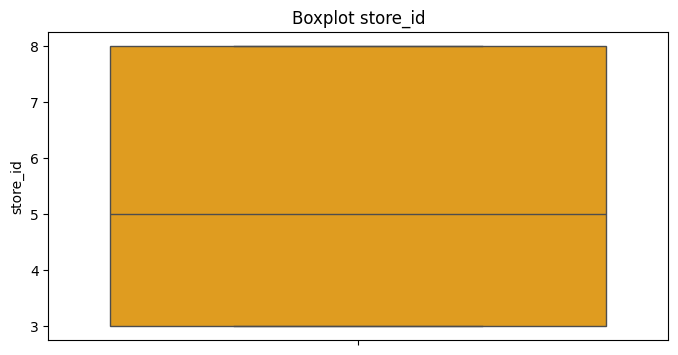

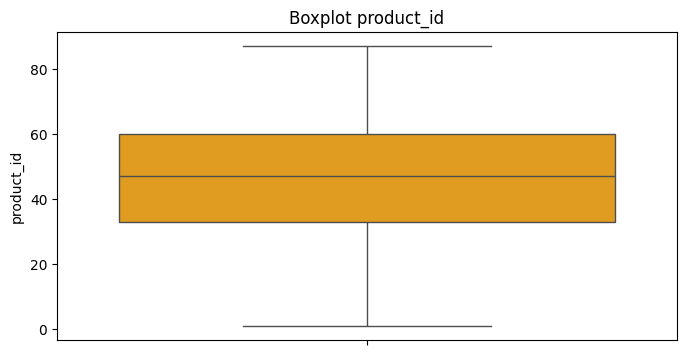

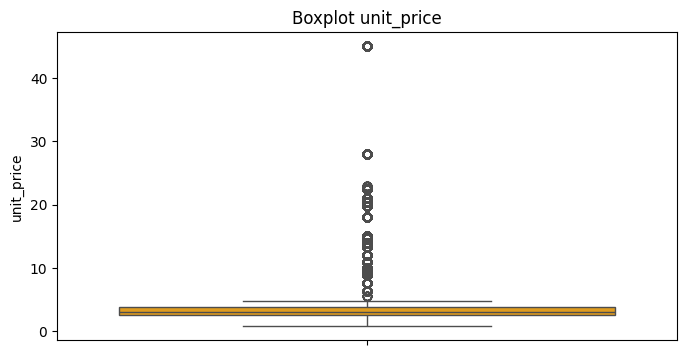

In [596]:
# Boxplot untuk mendeteksi outlier
for col in numeric_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=revenue_df, y=col, color='orange')
    plt.title(f'Boxplot {col}')
    plt.ylabel(col)
    plt.show()

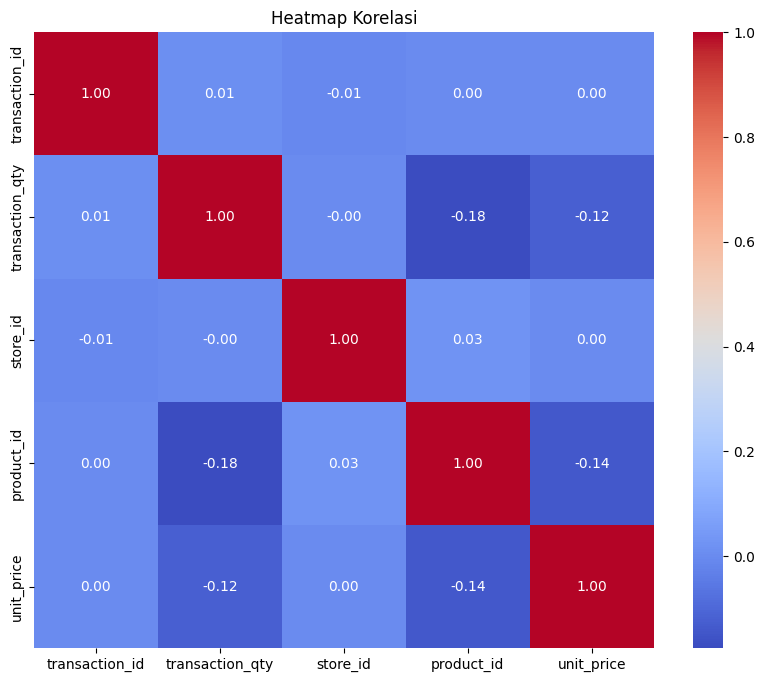

In [597]:
# Heatmap korelasi
plt.figure(figsize=(10, 8))
correlation_matrix = revenue_df[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap Korelasi')
plt.show()

## Data Prepocessing

In [598]:
# Fungsi untuk mendeteksi outliers menggunakan IQR
def detect_outliers_iqr(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers, lower_bound, upper_bound

# Deteksi outliers untuk setiap kolom numerik
for col in numeric_columns:
    outliers, lower_bound, upper_bound = detect_outliers_iqr(revenue_df[col])
    print(f"Kolom: {col}")
    print(f"Jumlah outliers: {len(outliers)}")
    print(f"Batas bawah: {lower_bound:.2f}, Batas atas: {upper_bound:.2f}")
    print("Nilai outliers:")
    print(outliers.to_markdown())
    print("\n")

Kolom: transaction_id
Jumlah outliers: 0
Batas bawah: -74802.00, Batas atas: 224232.00
Nilai outliers:
| transaction_id   |
|------------------|


Kolom: transaction_qty
Jumlah outliers: 36
Batas bawah: -0.50, Batas atas: 3.50
Nilai outliers:
|        |   transaction_qty |
|-------:|------------------:|
|   4163 |                 4 |
|   4352 |                 4 |
|   9310 |                 8 |
|   9365 |                 8 |
|  16490 |                 4 |
|  21416 |                 4 |
|  21532 |                 4 |
|  38494 |                 4 |
|  38550 |                 4 |
|  38707 |                 4 |
|  38953 |                 4 |
|  39176 |                 6 |
|  60777 |                 4 |
|  61057 |                 4 |
|  61317 |                 4 |
|  61622 |                 6 |
|  68806 |                 8 |
|  68981 |                 8 |
|  87847 |                 4 |
|  87987 |                 4 |
|  88557 |                 4 |
|  88616 |                 4 |
|  94332 |   

In [599]:
# Hapus outliers berdasarkan IQR
for col in numeric_columns:
    q1 = revenue_df[col].quantile(0.25)
    q3 = revenue_df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    revenue_df = revenue_df[(revenue_df[col] >= lower_bound) & (revenue_df[col] <= upper_bound)]

print("Dataset setelah penghapusan outliers:")
print(revenue_df.head().to_markdown())

Dataset setelah penghapusan outliers:
|    |   transaction_id | transaction_date   | transaction_time   |   transaction_qty |   store_id | store_location   |   product_id |   unit_price | product_category   | product_type          | product_detail              |   unit_price_log |
|---:|-----------------:|:-------------------|:-------------------|------------------:|-----------:|:-----------------|-------------:|-------------:|:-------------------|:----------------------|:----------------------------|-----------------:|
|  0 |                1 | 2023-01-01         | 07:06:11           |                 2 |          5 | Lower Manhattan  |           32 |          3   | Coffee             | Gourmet brewed coffee | Ethiopia Rg                 |          1.38629 |
|  1 |                2 | 2023-01-01         | 07:08:56           |                 2 |          5 | Lower Manhattan  |           57 |          3.1 | Tea                | Brewed Chai tea       | Spicy Eye Opener Chai Lg    |      

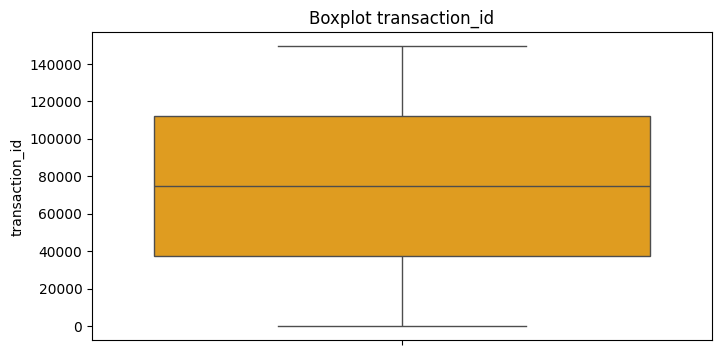

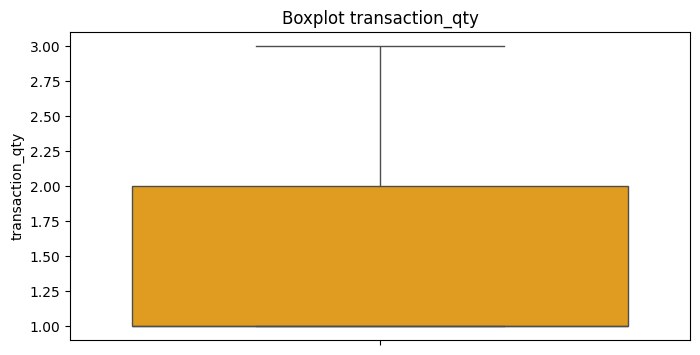

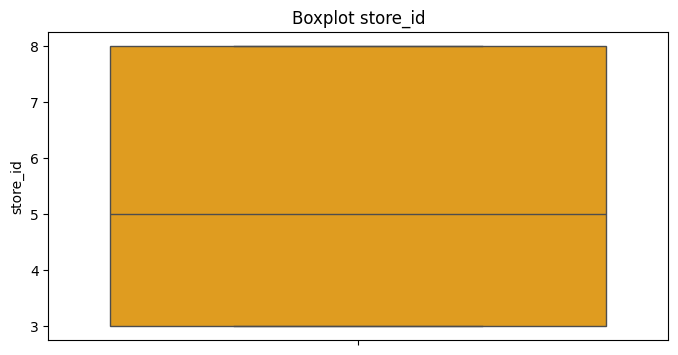

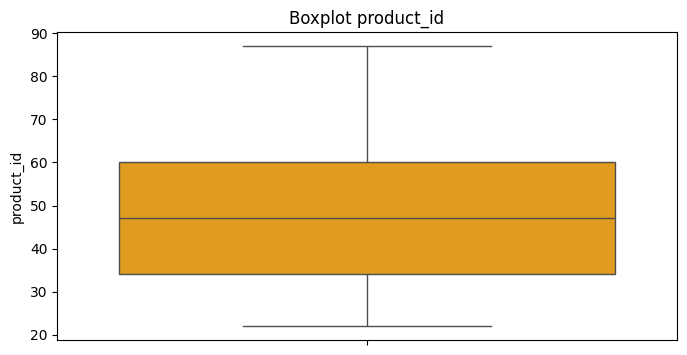

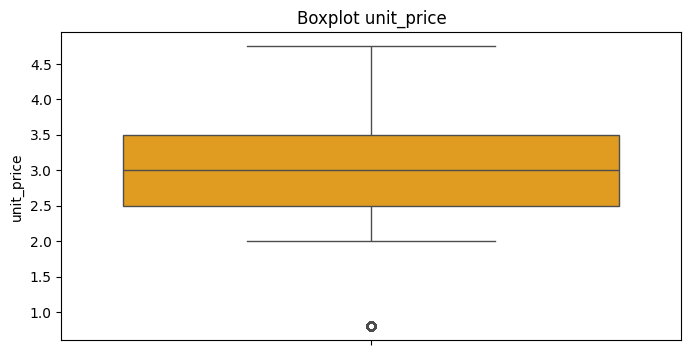

In [600]:
# Boxplot untuk mendeteksi outlier
for col in numeric_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=revenue_df, y=col, color='orange')
    plt.title(f'Boxplot {col}')
    plt.ylabel(col)
    plt.show()

In [601]:
# Encoding
categorical_columns = revenue_df.select_dtypes(include=['object']).columns
print("Kolom kategorikal:")
print(categorical_columns.to_list())

Kolom kategorikal:
['transaction_date', 'transaction_time', 'store_location', 'product_category', 'product_type', 'product_detail']


In [602]:
# Pilih kolom kategorikal
categorical_columns = revenue_df.select_dtypes(include=['object']).columns
print("Kolom kategorikal setelah penghapusan:")
print(list(categorical_columns))

Kolom kategorikal setelah penghapusan:
['transaction_date', 'transaction_time', 'store_location', 'product_category', 'product_type', 'product_detail']


In [603]:
# Terapkan One-Hot Encoding menggunakan pd.get_dummies()
revenue_df_onehot_encoded = pd.get_dummies(revenue_df, columns=categorical_columns)

print("Data setelah One-Hot Encoding (pd.get_dummies):")
print(revenue_df_onehot_encoded.head().to_markdown())

Data setelah One-Hot Encoding (pd.get_dummies):
|    |   transaction_id |   transaction_qty |   store_id |   product_id |   unit_price |   unit_price_log | transaction_date_2023-01-01   | transaction_date_2023-01-02   | transaction_date_2023-01-03   | transaction_date_2023-01-04   | transaction_date_2023-01-05   | transaction_date_2023-01-06   | transaction_date_2023-01-07   | transaction_date_2023-01-08   | transaction_date_2023-01-09   | transaction_date_2023-01-10   | transaction_date_2023-01-11   | transaction_date_2023-01-12   | transaction_date_2023-01-13   | transaction_date_2023-01-14   | transaction_date_2023-01-15   | transaction_date_2023-01-16   | transaction_date_2023-01-17   | transaction_date_2023-01-18   | transaction_date_2023-01-19   | transaction_date_2023-01-20   | transaction_date_2023-01-21   | transaction_date_2023-01-22   | transaction_date_2023-01-23   | transaction_date_2023-01-24   | transaction_date_2023-01-25   | transaction_date_2023-01-26   | transaction_

## Menghitung Revenue


In [604]:
# Hitung revenue per transaksi
revenue_df['revenue'] = revenue_df['transaction_qty'] * revenue_df['unit_price']

# 1. Analisis Revenue Berdasarkan Kategori Produk
revenue_by_category = revenue_df.groupby('product_category')['revenue'].agg(['sum', 'mean', 'count']).reset_index()
revenue_by_category.columns = ['Product_Category', 'Total_Revenue', 'Average_Revenue', 'Transaction_Count']

print("\nRevenue Berdasarkan Kategori Produk:")
print(revenue_by_category.to_markdown(index=False))


Revenue Berdasarkan Kategori Produk:
| Product_Category   |   Total_Revenue |   Average_Revenue |   Transaction_Count |
|:-------------------|----------------:|------------------:|--------------------:|
| Bakery             |         82231.2 |           3.60964 |               22781 |
| Coffee             |        269918   |           4.62078 |               58414 |
| Drinking Chocolate |         72416   |           6.31461 |               11468 |
| Flavours           |          8348   |           1.23291 |                6771 |
| Tea                |        196406   |           4.32146 |               45449 |


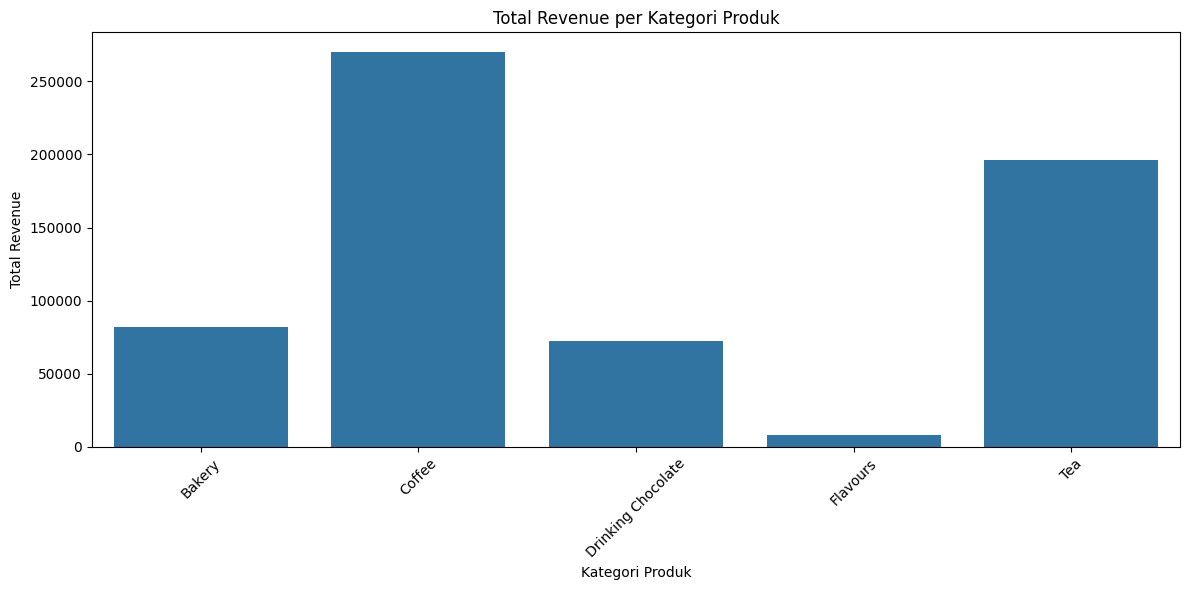

In [605]:
# Visualisasi Revenue per Kategori
plt.figure(figsize=(12, 6))
sns.barplot(data=revenue_by_category, x='Product_Category', y='Total_Revenue')
plt.xticks(rotation=45)
plt.title('Total Revenue per Kategori Produk')
plt.xlabel('Kategori Produk')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.show()

In [606]:
# 2. Analisis Revenue Berdasarkan Tipe Produk
revenue_by_type = revenue_df.groupby('product_type')['revenue'].agg(['sum', 'mean', 'count']).reset_index()
revenue_by_type.columns = ['Product_Type', 'Total_Revenue', 'Average_Revenue', 'Transaction_Count']

print("\nRevenue Berdasarkan Tipe Produk:")
print(revenue_by_type.to_markdown(index=False))


Revenue Berdasarkan Tipe Produk:
| Product_Type          |   Total_Revenue |   Average_Revenue |   Transaction_Count |
|:----------------------|----------------:|------------------:|--------------------:|
| Barista Espresso      |         91372.2 |           5.57114 |               16401 |
| Biscotti              |         19793.5 |           3.46586 |                5711 |
| Brewed Black tea      |         47932   |           4.22308 |               11350 |
| Brewed Chai tea       |         77081.9 |           4.48594 |               17183 |
| Brewed Green tea      |         23852.5 |           4.20605 |                5671 |
| Brewed herbal tea     |         47539.5 |           4.22761 |               11245 |
| Drip coffee           |         31984   |           3.77303 |                8477 |
| Gourmet brewed coffee |         70034.6 |           4.14112 |               16912 |
| Hot chocolate         |         72416   |           6.31461 |               11468 |
| Organic brewed cof

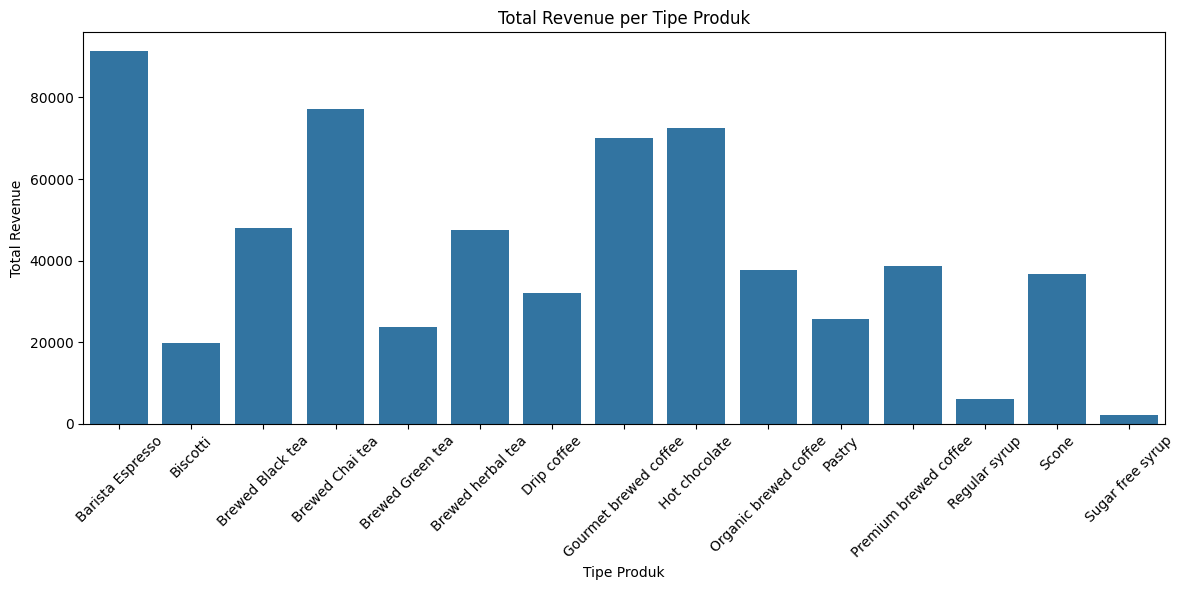

In [607]:
# Visualisasi Revenue per Tipe
plt.figure(figsize=(12, 6))
sns.barplot(data=revenue_by_type, x='Product_Type', y='Total_Revenue')
plt.xticks(rotation=45)
plt.title('Total Revenue per Tipe Produk')
plt.xlabel('Tipe Produk')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.show()

In [608]:
# 3. Analisis Distribusi Revenue Berdasarkan Lokasi
revenue_by_location = revenue_df.groupby('store_location')['revenue'].agg(['sum', 'mean', 'count']).reset_index()
revenue_by_location.columns = ['Store_Location', 'Total_Revenue', 'Average_Revenue', 'Transaction_Count']

print("\nRevenue Berdasarkan Lokasi Toko:")
print(revenue_by_location.to_markdown(index=False))


Revenue Berdasarkan Lokasi Toko:
| Store_Location   |   Total_Revenue |   Average_Revenue |   Transaction_Count |
|:-----------------|----------------:|------------------:|--------------------:|
| Astoria          |          212284 |           4.30038 |               49364 |
| Hell's Kitchen   |          209774 |           4.26249 |               49214 |
| Lower Manhattan  |          207262 |           4.47601 |               46305 |


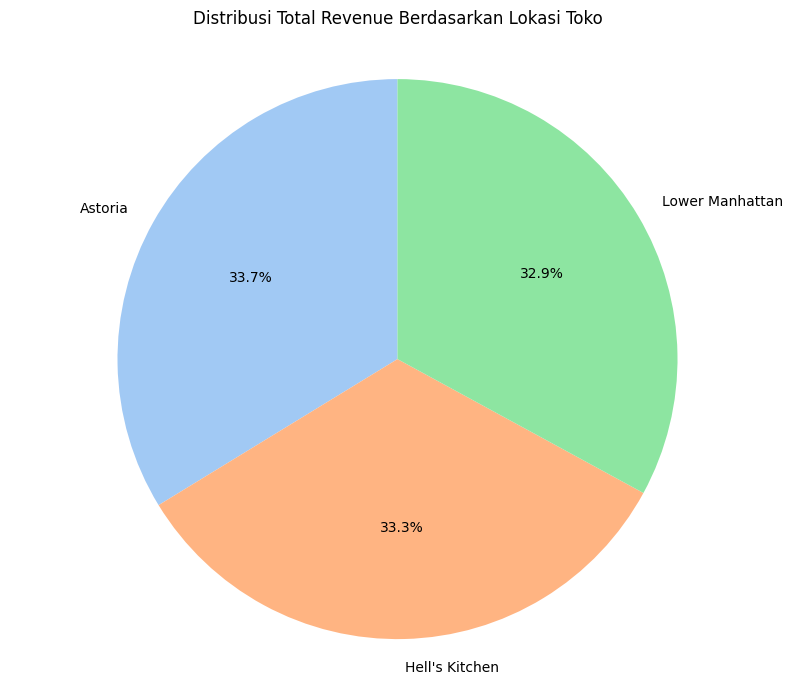

In [609]:
# Visualisasi Distribusi Revenue Berdasarkan Lokasi menggunakan Pie Chart
plt.figure(figsize=(10, 8))
plt.pie(revenue_by_location['Total_Revenue'],
        labels=revenue_by_location['Store_Location'],
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette('pastel'))
plt.title('Distribusi Total Revenue Berdasarkan Lokasi Toko', pad=20)
plt.axis('equal')
plt.show()

In [610]:
#  Analisis Growth Revenue
# Konversi transaction_date ke format datetime
revenue_df['transaction_date'] = pd.to_datetime(revenue_df['transaction_date'])

# Ekstrak informasi tanggal (tahun, bulan, minggu, hari)
revenue_df['year'] = revenue_df['transaction_date'].dt.year
revenue_df['month'] = revenue_df['transaction_date'].dt.month
revenue_df['week'] = revenue_df['transaction_date'].dt.isocalendar().week
revenue_df['day'] = revenue_df['transaction_date'].dt.day


Revenue Bulanan dan Pertumbuhan:
| year_month   |   revenue |    growth |
|:-------------|----------:|----------:|
| 2023-01      |   72709   | nan       |
| 2023-02      |   69097.4 |  -4.96722 |
| 2023-03      |   89518.3 |  29.5537  |
| 2023-04      |  107003   |  19.5319  |
| 2023-05      |  141641   |  32.3714  |
| 2023-06      |  149351   |   5.44296 |


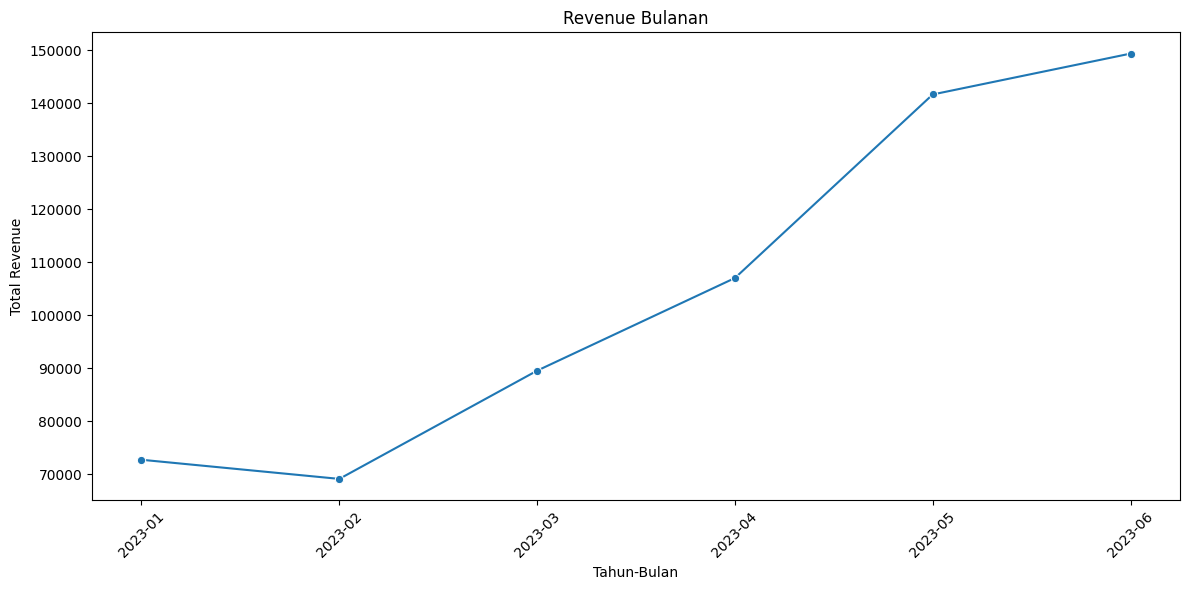

In [611]:
# 1. Analisis Growth Revenue Bulanan
monthly_revenue = revenue_df.groupby(['year', 'month'])['revenue'].sum().reset_index()
monthly_revenue['year_month'] = monthly_revenue['year'].astype(str) + '-' + monthly_revenue['month'].astype(str).str.zfill(2)
monthly_revenue['growth'] = monthly_revenue['revenue'].pct_change() * 100

print("\nRevenue Bulanan dan Pertumbuhan:")
print(monthly_revenue[['year_month', 'revenue', 'growth']].to_markdown(index=False))

# Visualisasi Revenue Bulanan
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_revenue, x='year_month', y='revenue', marker='o')
plt.xticks(rotation=45)
plt.title('Revenue Bulanan')
plt.xlabel('Tahun-Bulan')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.show()

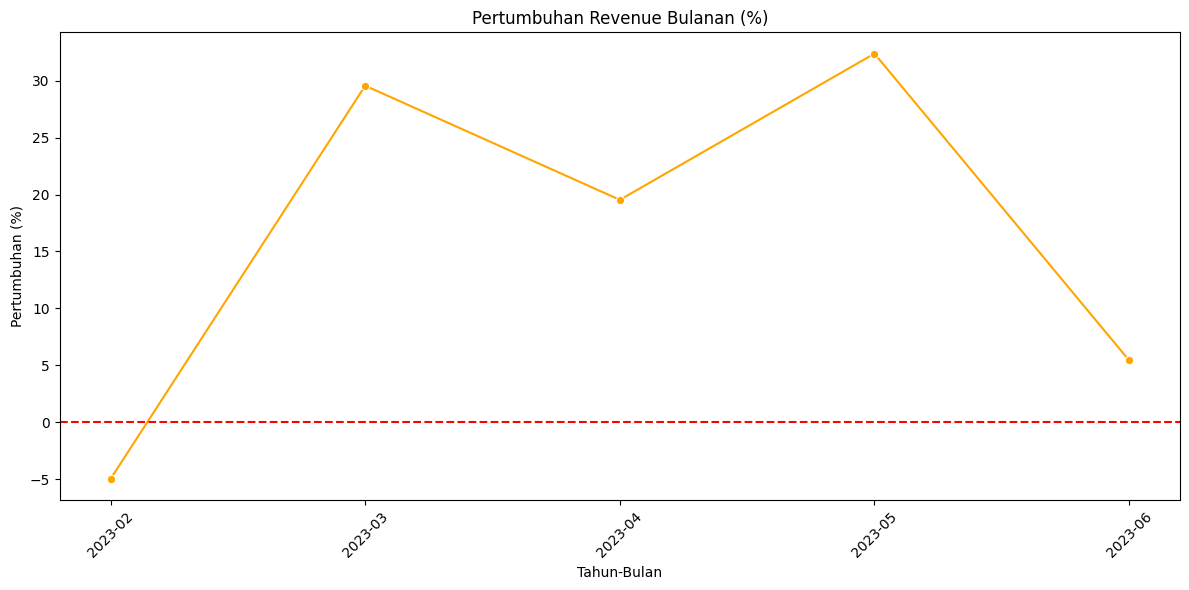

In [612]:
# Visualisasi Pertumbuhan Revenue Bulanan
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_revenue, x='year_month', y='growth', marker='o', color='orange')
plt.axhline(0, color='red', linestyle='--')
plt.xticks(rotation=45)
plt.title('Pertumbuhan Revenue Bulanan (%)')
plt.xlabel('Tahun-Bulan')
plt.ylabel('Pertumbuhan (%)')
plt.tight_layout()
plt.show()


Revenue Mingguan dan Pertumbuhan:
| year_week   |   revenue |     growth |
|:------------|----------:|-----------:|
| 2023-W01    |   16519   | nan        |
| 2023-W02    |   16419.4 |  -0.60246  |
| 2023-W03    |   16166.6 |  -1.53952  |
| 2023-W04    |   17198.9 |   6.38506  |
| 2023-W05    |   16318   |  -5.12207  |
| 2023-W06    |   16417.3 |   0.608593 |
| 2023-W07    |   17026.6 |   3.71152  |
| 2023-W08    |   18019.9 |   5.83381  |
| 2023-W09    |   20131.2 |  11.7168   |
| 2023-W10    |   19515.8 |  -3.05744  |
| 2023-W11    |   19884.8 |   1.89104  |
| 2023-W12    |   21158.5 |   6.40514  |
| 2023-W13    |   21316.4 |   0.746368 |
| 2023-W14    |   24315.3 |  14.0689   |
| 2023-W15    |   24861.2 |   2.24467  |
| 2023-W16    |   24607.6 |  -1.01986  |
| 2023-W17    |   25943   |   5.4269   |
| 2023-W18    |   31835.9 |  22.7147   |
| 2023-W19    |   31185.8 |  -2.04219  |
| 2023-W20    |   32017.1 |   2.6658   |
| 2023-W21    |   34271   |   7.03968  |
| 2023-W22    |   3276

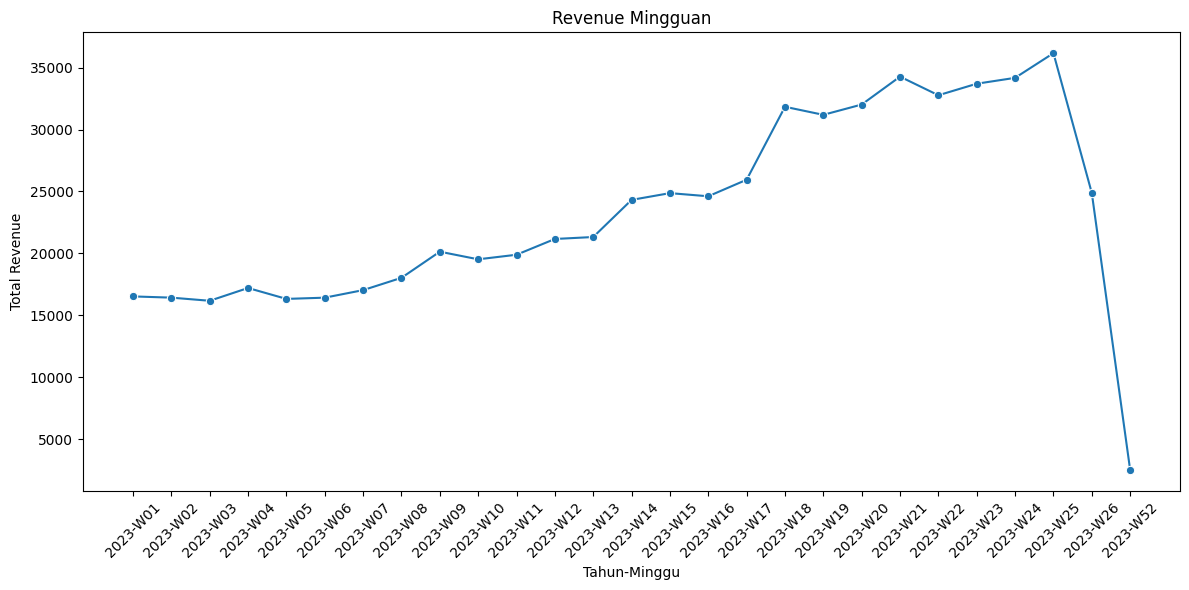

In [613]:
# 2. Analisis Growth Revenue Mingguan
weekly_revenue = revenue_df.groupby(['year', 'week'])['revenue'].sum().reset_index()
weekly_revenue['year_week'] = weekly_revenue['year'].astype(str) + '-W' + weekly_revenue['week'].astype(str).str.zfill(2)
weekly_revenue['growth'] = weekly_revenue['revenue'].pct_change() * 100

print("\nRevenue Mingguan dan Pertumbuhan:")
print(weekly_revenue[['year_week', 'revenue', 'growth']].to_markdown(index=False))

# Visualisasi Revenue Mingguan
plt.figure(figsize=(12, 6))
sns.lineplot(data=weekly_revenue, x='year_week', y='revenue', marker='o')
plt.xticks(rotation=45)
plt.title('Revenue Mingguan')
plt.xlabel('Tahun-Minggu')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.show()

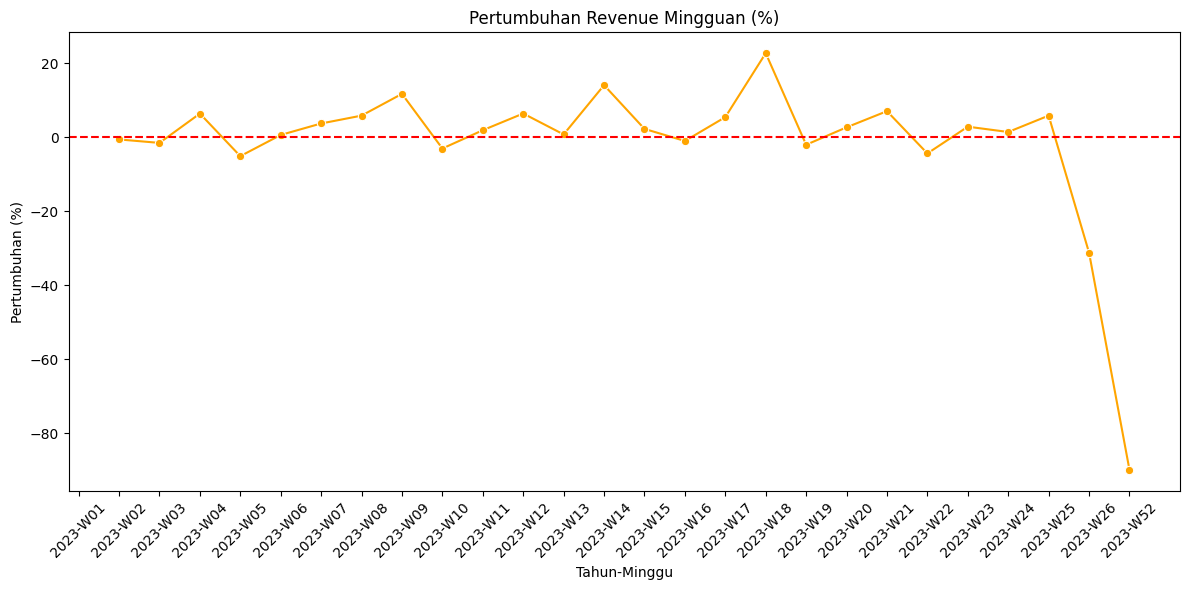

In [614]:
# Visualisasi Pertumbuhan Revenue Mingguan
plt.figure(figsize=(12, 6))
sns.lineplot(data=weekly_revenue, x='year_week', y='growth', marker='o', color='orange')
plt.axhline(0, color='red', linestyle='--')
plt.xticks(rotation=45)
plt.title('Pertumbuhan Revenue Mingguan (%)')
plt.xlabel('Tahun-Minggu')
plt.ylabel('Pertumbuhan (%)')
plt.tight_layout()
plt.show()

In [615]:
# Tambahan: Analisis Pertumbuhan per Segmen
# 3. Analisis Growth Revenue Bulanan per Kategori Produk
monthly_revenue_by_category = revenue_df.groupby(['year', 'month', 'product_category'])['revenue'].sum().reset_index()
monthly_revenue_by_category['year_month'] = monthly_revenue_by_category['year'].astype(str) + '-' + monthly_revenue_by_category['month'].astype(str).str.zfill(2)
monthly_revenue_by_category['growth'] = monthly_revenue_by_category.groupby('product_category')['revenue'].pct_change() * 100

print("\nRevenue Bulanan dan Pertumbuhan per Kategori Produk:")
print(monthly_revenue_by_category[['year_month', 'product_category', 'revenue', 'growth']].to_markdown(index=False))


Revenue Bulanan dan Pertumbuhan per Kategori Produk:
| year_month   | product_category   |   revenue |    growth |
|:-------------|:-------------------|----------:|----------:|
| 2023-01      | Bakery             |   9524.49 | nan       |
| 2023-01      | Coffee             |  31256.8  | nan       |
| 2023-01      | Drinking Chocolate |   8337.75 | nan       |
| 2023-01      | Flavours           |    968    | nan       |
| 2023-01      | Tea                |  22622    | nan       |
| 2023-02      | Bakery             |   9038.82 |  -5.09917 |
| 2023-02      | Coffee             |  29269    |  -6.35989 |
| 2023-02      | Drinking Chocolate |   8132.25 |  -2.46469 |
| 2023-02      | Flavours           |    924    |  -4.54545 |
| 2023-02      | Tea                |  21733.4  |  -3.92782 |
| 2023-03      | Bakery             |  11891.3  |  31.5583  |
| 2023-03      | Coffee             |  38303.6  |  30.8677  |
| 2023-03      | Drinking Chocolate |  10253.5  |  26.0844  |
| 2023-03      |

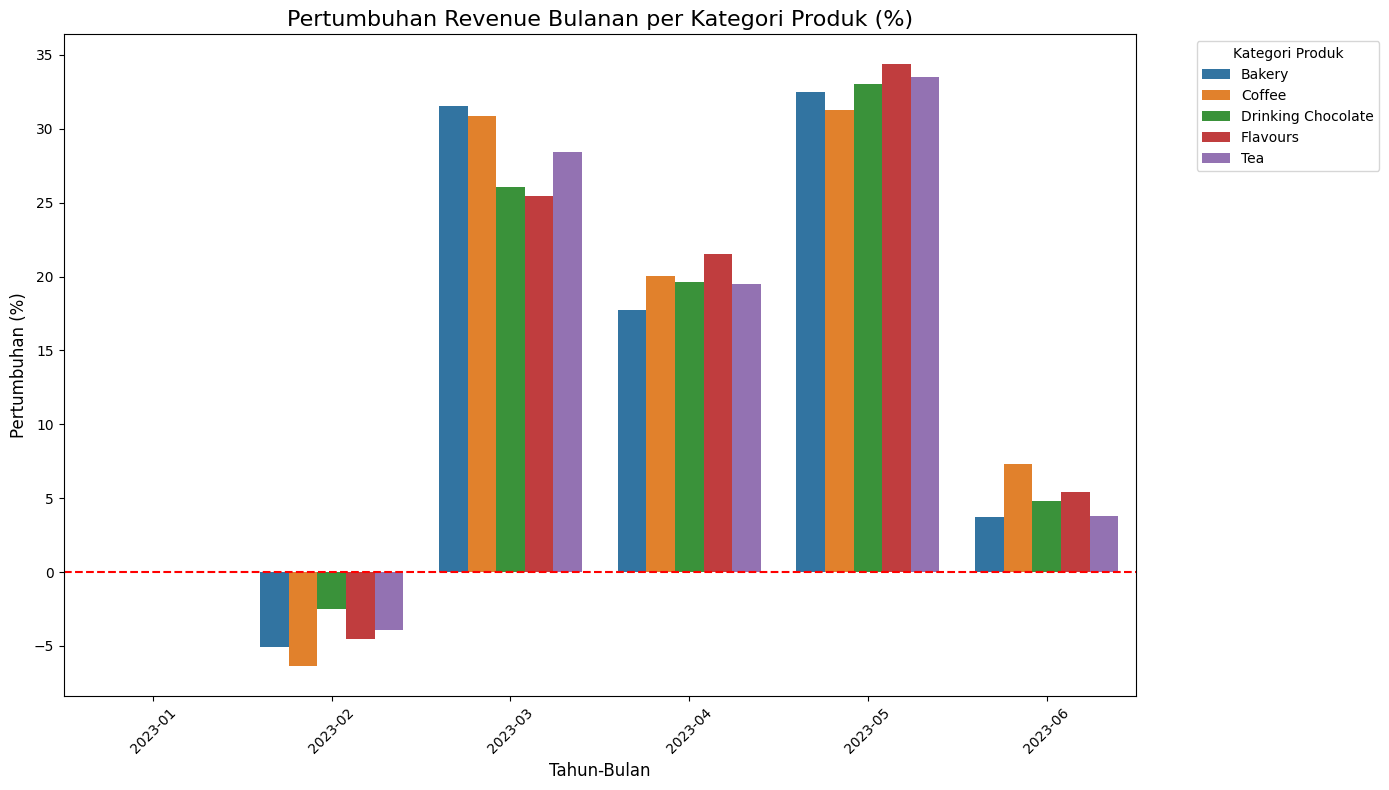

In [616]:
# Visualisasi
plt.figure(figsize=(14, 8))


sns.barplot(data=monthly_revenue_by_category, x='year_month', y='growth', hue='product_category')


plt.axhline(0, color='red', linestyle='--')
plt.xticks(rotation=45)
plt.title('Pertumbuhan Revenue Bulanan per Kategori Produk (%)', fontsize=16)
plt.xlabel('Tahun-Bulan', fontsize=12)
plt.ylabel('Pertumbuhan (%)', fontsize=12)
plt.legend(title='Kategori Produk', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [617]:
# 4. Analisis Growth Revenue Bulanan per Tipe Produk
monthly_revenue_by_type = revenue_df.groupby(['year', 'month', 'product_type'])['revenue'].sum().reset_index()
monthly_revenue_by_type['year_month'] = monthly_revenue_by_type['year'].astype(str) + '-' + monthly_revenue_by_type['month'].astype(str).str.zfill(2)
monthly_revenue_by_type['growth'] = monthly_revenue_by_type.groupby('product_type')['revenue'].pct_change() * 100

print("\nRevenue Bulanan dan Pertumbuhan per Tipe Produk:")
print(monthly_revenue_by_type[['year_month', 'product_type', 'revenue', 'growth']].to_markdown(index=False))


Revenue Bulanan dan Pertumbuhan per Tipe Produk:
| year_month   | product_type          |   revenue |    growth |
|:-------------|:----------------------|----------:|----------:|
| 2023-01      | Barista Espresso      |  10461.2  | nan       |
| 2023-01      | Biscotti              |   2311.02 | nan       |
| 2023-01      | Brewed Black tea      |   5535.5  | nan       |
| 2023-01      | Brewed Chai tea       |   8761.45 | nan       |
| 2023-01      | Brewed Green tea      |   2883.5  | nan       |
| 2023-01      | Brewed herbal tea     |   5441.5  | nan       |
| 2023-01      | Drip coffee           |   3583.5  | nan       |
| 2023-01      | Gourmet brewed coffee |   8072.1  | nan       |
| 2023-01      | Hot chocolate         |   8337.75 | nan       |
| 2023-01      | Organic brewed coffee |   4609.1  | nan       |
| 2023-01      | Pastry                |   2875.58 | nan       |
| 2023-01      | Premium brewed coffee |   4530.95 | nan       |
| 2023-01      | Regular syrup         |

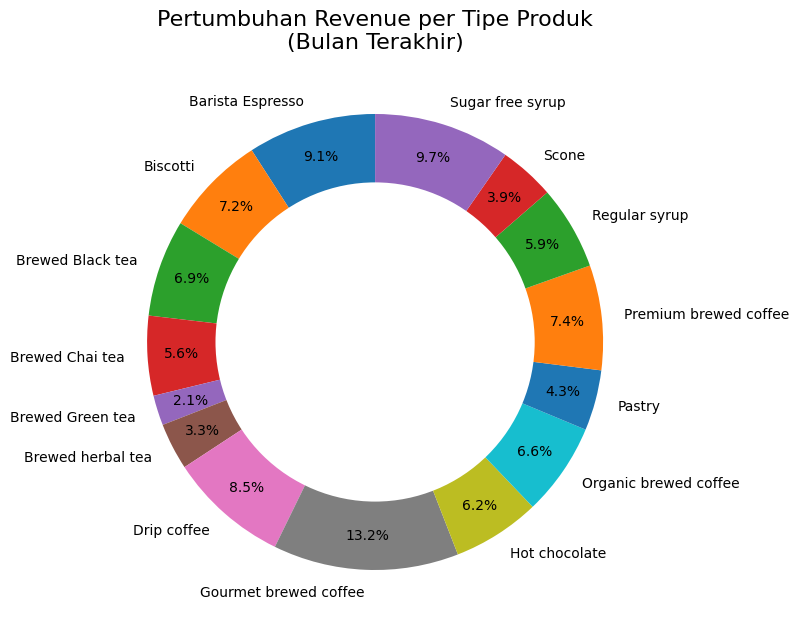

In [618]:
# Visualisasi Growth per tipe produk
last_month_data = monthly_revenue_by_type[monthly_revenue_by_type['year_month'] == monthly_revenue_by_type['year_month'].max()]
growth_values = last_month_data['growth']
product_types = last_month_data['product_type']
plt.figure(figsize=(8, 8))
plt.pie(growth_values, labels=product_types, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Pertumbuhan Revenue per Tipe Produk\n(Bulan Terakhir)', fontsize=16)
plt.tight_layout()
plt.show()

In [619]:
# 5. Analisis Growth Revenue Bulanan per Lokasi Toko
monthly_revenue_by_location = revenue_df.groupby(['year', 'month', 'store_location'])['revenue'].sum().reset_index()
monthly_revenue_by_location['year_month'] = monthly_revenue_by_location['year'].astype(str) + '-' + monthly_revenue_by_location['month'].astype(str).str.zfill(2)
monthly_revenue_by_location['growth'] = monthly_revenue_by_location.groupby('store_location')['revenue'].pct_change() * 100

print("\nRevenue Bulanan dan Pertumbuhan per Lokasi Toko:")
print(monthly_revenue_by_location[['year_month', 'store_location', 'revenue', 'growth']].to_markdown(index=False))


Revenue Bulanan dan Pertumbuhan per Lokasi Toko:
| year_month   | store_location   |   revenue |    growth |
|:-------------|:-----------------|----------:|----------:|
| 2023-01      | Astoria          |   24644.3 | nan       |
| 2023-01      | Hell's Kitchen   |   24297.3 | nan       |
| 2023-01      | Lower Manhattan  |   23767.4 | nan       |
| 2023-02      | Astoria          |   23155   |  -6.04339 |
| 2023-02      | Hell's Kitchen   |   23169.1 |  -4.64351 |
| 2023-02      | Lower Manhattan  |   22773.4 |  -4.18229 |
| 2023-03      | Astoria          |   29898.7 |  29.1242  |
| 2023-03      | Hell's Kitchen   |   29896   |  29.0337  |
| 2023-03      | Lower Manhattan  |   29723.7 |  30.5194  |
| 2023-04      | Astoria          |   36020.2 |  20.4743  |
| 2023-04      | Hell's Kitchen   |   35683.3 |  19.3585  |
| 2023-04      | Lower Manhattan  |   35299.3 |  18.7583  |
| 2023-05      | Astoria          |   48145.5 |  33.6625  |
| 2023-05      | Hell's Kitchen   |   46661.4 |  3

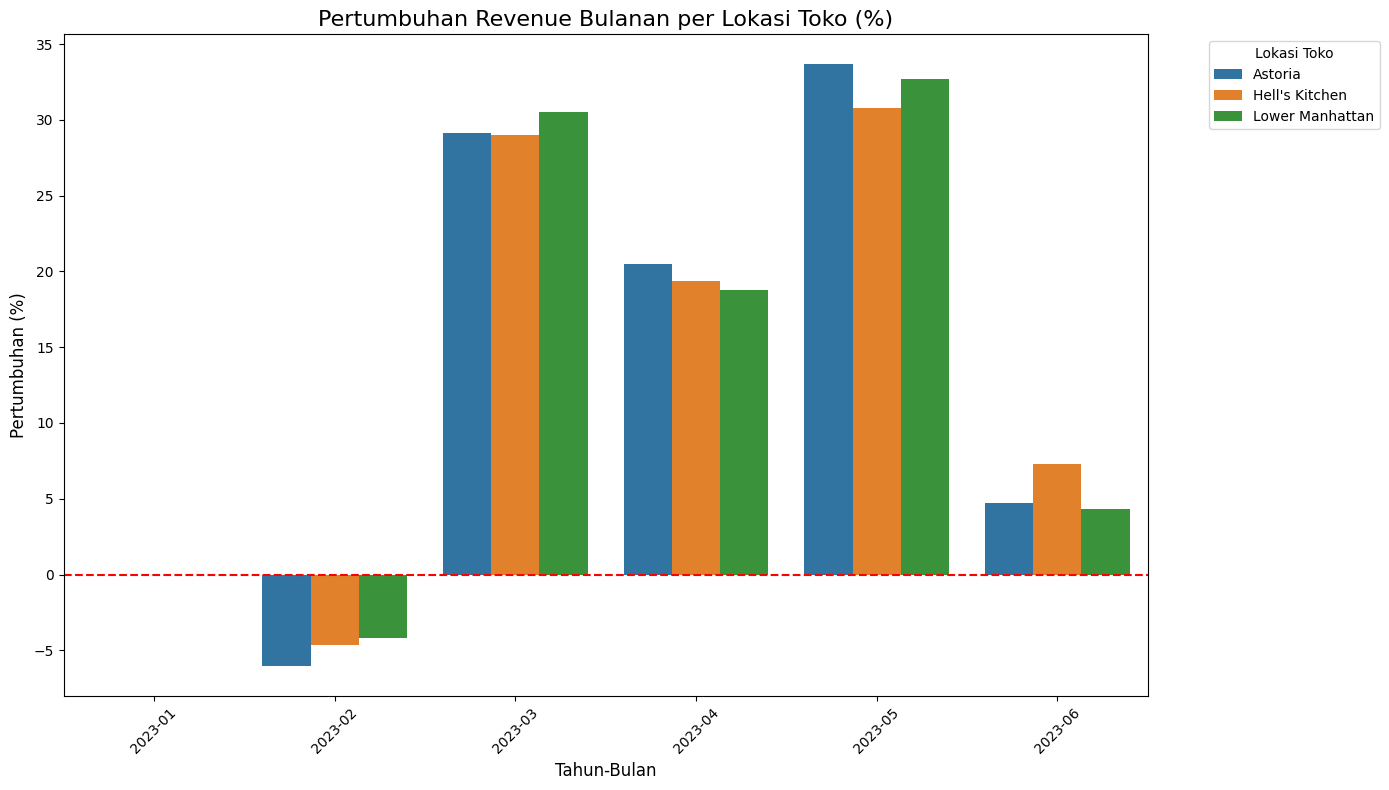

In [620]:

# Visualisasi
plt.figure(figsize=(14, 8))


sns.barplot(data=monthly_revenue_by_location, x='year_month', y='growth', hue='store_location')


plt.axhline(0, color='red', linestyle='--')
plt.xticks(rotation=45)
plt.title('Pertumbuhan Revenue Bulanan per Lokasi Toko (%)', fontsize=16)
plt.xlabel('Tahun-Bulan', fontsize=12)
plt.ylabel('Pertumbuhan (%)', fontsize=12)
plt.legend(title='Lokasi Toko', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Modeling

## Model 1 Elastic Net Regression

In [621]:
# Definisikan fitur dan target
X = revenue_df.drop(columns=['revenue', 'transaction_date', 'transaction_id', 'transaction_time', 'store_id', 'product_id', 'year', 'month', 'week', 'day'])
y = revenue_df['revenue']

# Pra-pemrosesan untuk model regresi
numeric_features = ['transaction_qty', 'unit_price', 'unit_price_log']
categorical_features = ['store_location', 'product_category', 'product_type', 'product_detail']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

# Pemisahan data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [622]:
# 1. Prediksi Revenue dengan Elastic Net Regression
enet_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet(random_state=42))
])

# Hyperparameter tuning
param_grid_enet = {
    'regressor__alpha': [0.1, 1.0, 10.0],
    'regressor__l1_ratio': [0.1, 0.5, 0.9]
}
grid_search_enet = GridSearchCV(enet_pipeline, param_grid_enet, cv=5, scoring='r2', n_jobs=-1)
grid_search_enet.fit(X_train, y_train)

# Model terbaik
best_enet = grid_search_enet.best_estimator_
y_train_pred_enet = best_enet.predict(X_train)
y_test_pred_enet = best_enet.predict(X_test)

In [623]:
# Evaluasi
train_mse_enet = mean_squared_error(y_train, y_train_pred_enet)
test_mse_enet = mean_squared_error(y_test, y_test_pred_enet)
train_r2_enet = r2_score(y_train, y_train_pred_enet)
test_r2_enet = r2_score(y_test, y_test_pred_enet)
cv_scores_enet = cross_val_score(best_enet, X, y, cv=5, scoring='r2')

print("\nHasil Evaluasi Elastic Net Regression:")
print(f"Best Parameters: {grid_search_enet.best_params_}")
print(f"Training MSE: {train_mse_enet:.2f}")
print(f"Testing MSE: {test_mse_enet:.2f}")
print(f"Training R² Score: {train_r2_enet:.4f}")
print(f"Testing R² Score: {test_r2_enet:.4f}")
print(f"Cross-Validation R² Mean: {cv_scores_enet.mean():.4f}")


Hasil Evaluasi Elastic Net Regression:
Best Parameters: {'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.9}
Training MSE: 0.21
Testing MSE: 0.22
Training R² Score: 0.9452
Testing R² Score: 0.9438
Cross-Validation R² Mean: 0.9451


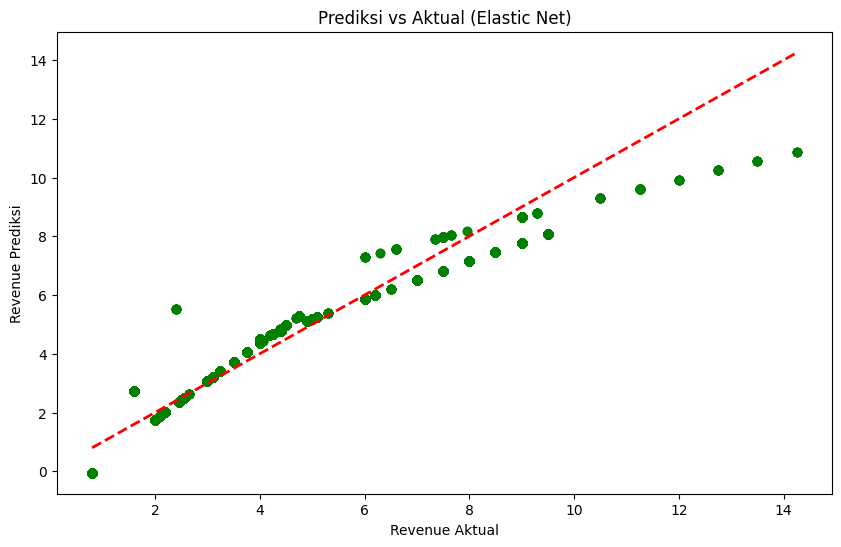

In [624]:
# Visualisasi
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_enet, color='green', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Revenue Aktual')
plt.ylabel('Revenue Prediksi')
plt.title('Prediksi vs Aktual (Elastic Net)')
plt.show()

## Model 2 Linear Regression

In [625]:
# Definisikan fitur dan target
X = revenue_df.drop(columns=['revenue', 'transaction_date', 'transaction_id', 'transaction_time', 'store_id', 'product_id', 'year', 'month', 'week', 'day'])
y = revenue_df['revenue']

# Pra-pemrosesan untuk model regresi
numeric_features = ['transaction_qty', 'unit_price', 'unit_price_log']
categorical_features = ['store_location', 'product_category', 'product_type', 'product_detail']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

# Pemisahan data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [626]:

#  2. Linear Regression
linear_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Latih model Linear Regression
linear_pipeline.fit(X_train, y_train)

# Prediksi
y_train_pred_linear = linear_pipeline.predict(X_train)
y_test_pred_linear = linear_pipeline.predict(X_test)

In [627]:
# Evaluasi
train_mse_linear = mean_squared_error(y_train, y_train_pred_linear)
test_mse_linear = mean_squared_error(y_test, y_test_pred_linear)
train_r2_linear = r2_score(y_train, y_train_pred_linear)
test_r2_linear = r2_score(y_test, y_test_pred_linear)

print("\nHasil Evaluasi Linear Regression:")
print(f"Training MSE: {train_mse_linear:.2f}")
print(f"Testing MSE: {test_mse_linear:.2f}")
print(f"Training R² Score: {train_r2_linear:.4f}")
print(f"Testing R² Score: {test_r2_linear:.4f}")


Hasil Evaluasi Linear Regression:
Training MSE: 0.17
Testing MSE: 0.18
Training R² Score: 0.9554
Testing R² Score: 0.9550


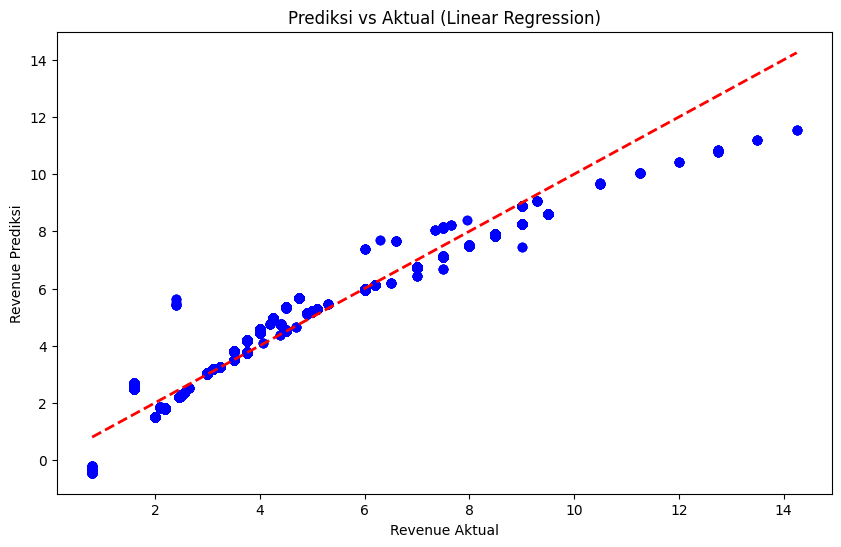

In [628]:
# Visualisasi
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_linear, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Revenue Aktual')
plt.ylabel('Revenue Prediksi')
plt.title('Prediksi vs Aktual (Linear Regression)')
plt.show()

In [629]:

# --- Perbandingan Performa Model ---
print("\nPerbandingan Performa Model:")
print("Elastic Net Regression (Prediksi Revenue):")
print(f"Training MSE: {train_mse_enet:.2f}, Testing MSE: {test_mse_enet:.2f}")
print(f"Training R²: {train_r2_enet:.4f}, Testing R²: {test_r2_enet:.4f}")
print("Linear Regression (Prediksi Revenue):")
print(f"Training MSE: {train_mse_linear:.2f}, Testing MSE: {test_mse_linear:.2f}")
print(f"Training R²: {train_r2_linear:.4f}, Testing R²: {test_r2_linear:.4f}")


Perbandingan Performa Model:
Elastic Net Regression (Prediksi Revenue):
Training MSE: 0.21, Testing MSE: 0.22
Training R²: 0.9452, Testing R²: 0.9438
Linear Regression (Prediksi Revenue):
Training MSE: 0.17, Testing MSE: 0.18
Training R²: 0.9554, Testing R²: 0.9550
